In [28]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


import h5py
#from read_raw import load_from_file
import maxlab_analysis as mla

import time
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [29]:
filename = "batch2_20439div15.data.raw.h5"


# Read data/make .npy

writing frames 0 to 640000 out of 12001600
writing frames 640000 to 1280000 out of 12001600
writing frames 1280000 to 1920000 out of 12001600
writing frames 1920000 to 2560000 out of 12001600
writing frames 2560000 to 3200000 out of 12001600
writing frames 3200000 to 3840000 out of 12001600
writing frames 3840000 to 4480000 out of 12001600
writing frames 4480000 to 5120000 out of 12001600
writing frames 5120000 to 5760000 out of 12001600
writing frames 5760000 to 6400000 out of 12001600
writing frames 6400000 to 7040000 out of 12001600
writing frames 7040000 to 7680000 out of 12001600
writing frames 7680000 to 8320000 out of 12001600
writing frames 8320000 to 8960000 out of 12001600
writing frames 8960000 to 9600000 out of 12001600
writing frames 9600000 to 10240000 out of 12001600
writing frames 10240000 to 10880000 out of 12001600
writing frames 10880000 to 11520000 out of 12001600
writing frames 11520000 to 12001600 out of 12001600
(19600, 1018)
(19600,)


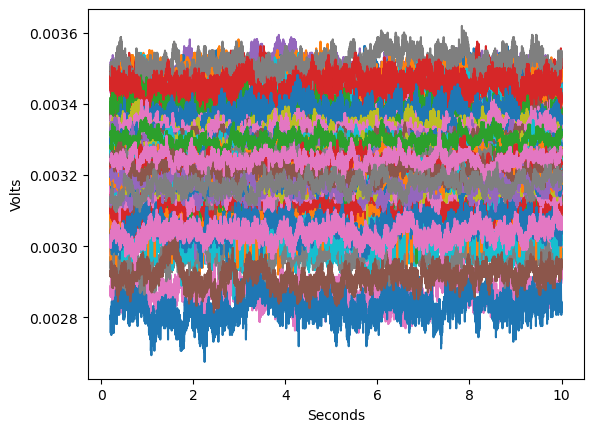

In [30]:
mla.recording_to_npy(filename, 0, 0)

X, t = mla.load_from_file(filename, 0, 0, 0.2, 10 , 2000)
print(np.shape(X))
print(np.shape(t))
plt.plot(t,X[:,:]);
plt.ylabel('Volts');
plt.xlabel('Seconds');


plt.show()

# plt.savefig('plot.png')

# Burst detection

In [31]:
Y = mla.load_spikes_from_file(filename, 0, 0, -10)
print(np.shape(Y))
print(Y)

(169212, 3)


time taken: 12.921169519424438 s
           time channel  amplitude
16432  13.15855     215 -13.069085
16434  13.15910     333 -17.037502
16435  13.15960     956 -13.580862
16436  13.16005     259 -10.342632
16437  13.16100     453 -16.946474
     time  fraction channels active
0  13.150                  0.507264
1  14.075                  0.391041
2  28.075                  0.453995
3  29.125                  0.389831
4  46.725                  0.447942


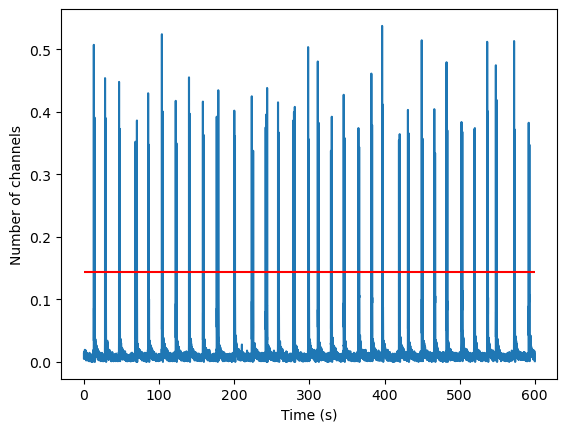

In [32]:
start_time = time.time()
Y_synchronized, spike_times = mla.find_synchronized_spikes(Y, plot_firing = True)
end_time = time.time()
print('time taken: ' + str(end_time - start_time) + ' s')
print(Y_synchronized.head())
print(spike_times.head())

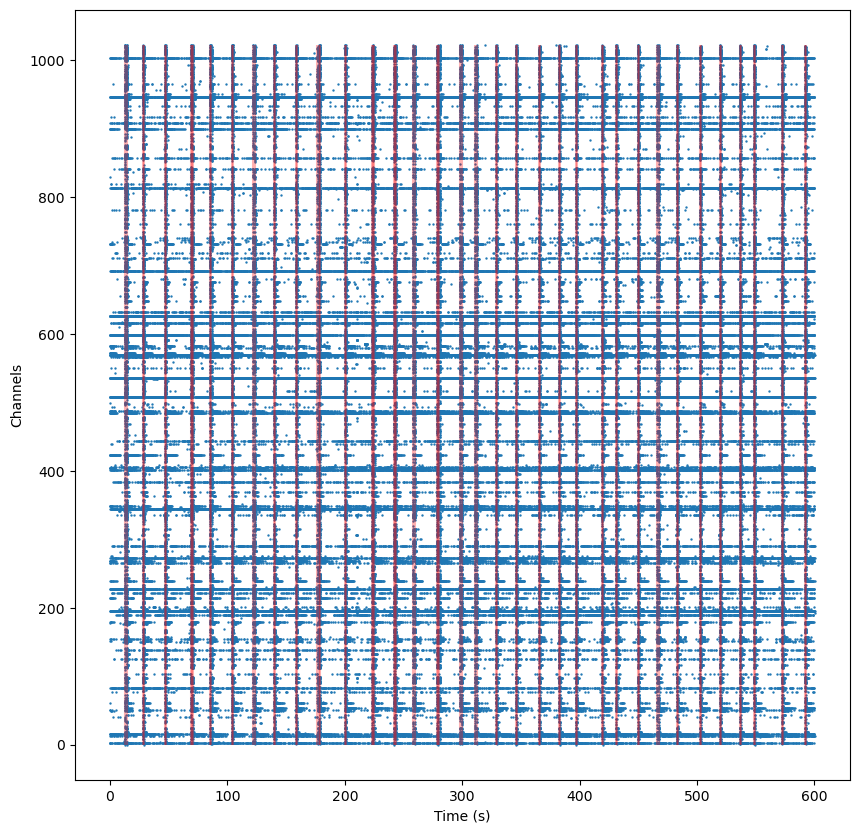

In [33]:
plt.figure(figsize = (10, 10))
plt.scatter(Y['time'], Y['channel'], 0.5)
#plt.scatter(Y_synchronized['frameno'], Y_synchronized['channel'], 1, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Channels')
plt.vlines(spike_times['time'], 0, max(Y['channel']), 'red', alpha=0.3)

In [34]:
spike_diffs = spike_times.diff().dropna()
num_bins = 'auto'

Text(0, 0.5, '$P(IBI) < t$')

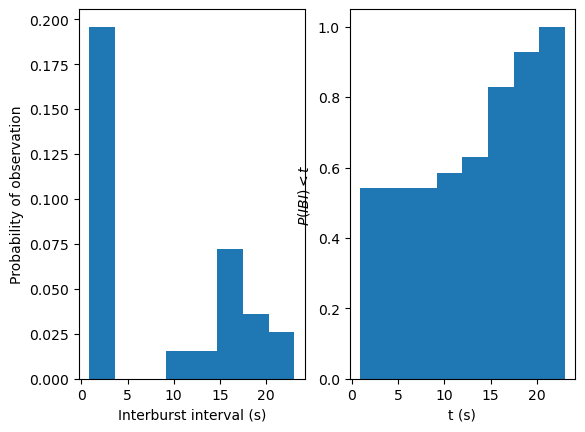

In [35]:
#num_bins = 1000

plt.figure()
plt.subplot(121)
plt.hist(spike_diffs['time'], num_bins, density = True)
plt.xlabel('Interburst interval (s)')
plt.ylabel('Probability of observation')


plt.subplot(122)
plt.hist(spike_diffs['time'], num_bins, density = True, cumulative = True)
plt.xlabel('t (s)')
plt.ylabel('$P(IBI) < t$')

In [36]:

try:
    IBI_hist = np.histogram(spike_diffs['time'], bins = num_bins, density = True)
    (IBI_data, IBI_bins) = IBI_hist
    IBI_bin_midpoints = [(a + b) /2 for a,b in zip(IBI_bins[:-1], IBI_bins[1:])]

    hist_dist = stats.rv_histogram(IBI_hist, density = True)
    X = np.linspace(0, max(spike_diffs['time']), 500)

    plt.figure()
    plt.subplot(131)
    plt.title('IBI distribution')
    plt.scatter(IBI_bin_midpoints, IBI_data)
    #plt.plot(X, hist_dist.pdf(X), label= 'PDF')
    #plt.plot(X, hist_dist.cdf(X), label= 'CDF')

    plt.legend()

    plt.xlabel('Interburst interval (s)')
    plt.ylabel('Probability of observation')
    plt.yscale('log')
    plt.xscale('log')

    plt.subplot(132)
    #NOTE - THIS NAN_TO_NUM THING IS HAPPENING
    log_IBI_bin_midpoints = np.log(IBI_bin_midpoints)
    log_IBI_data = np.log1p(IBI_data)

    fit = stats.linregress(log_IBI_bin_midpoints, log_IBI_data)
    plt.plot(log_IBI_bin_midpoints, fit.intercept + fit.slope*log_IBI_bin_midpoints, 'r', label=f'fitted line, $r^2 = {fit.rvalue**2:.2f}$')

    plt.title('IBI distribution, log/log')
    #plt.hist(spike_diffs['time'], num_bins, density = True)
    plt.plot(log_IBI_bin_midpoints, log_IBI_data, label = "log fit")
    #plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
    #plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

    plt.legend()

    plt.xlabel('log(Interburst interval (s))')
    plt.ylabel('log(Probability of observation)')

    plt.subplot(133)
    plt.title('IBI distribution, log/log')
    #plt.hist(spike_diffs['time'], num_bins, density = True)
    plt.loglog(IBI_bin_midpoints, IBI_data, label = "log fit")
    plt.loglog(X, hist_dist.pdf(X), label= 'PDF')
    plt.loglog(X, hist_dist.cdf(X), label= 'CDF')

    plt.legend()

    #plt.xlabel('log(Interburst interval (s))')
    #plt.ylabel('log(Probability of observation)')
except:
    pass